# Stool vs TongueDorsum

In [1]:
suppressMessages({
    library(phyloseq)
    library(DESeq2)
    library(SummarizedExperiment)
    library(magrittr)
    library(dplyr)
    library(tidyr)
    library(ggplot2)
})

In [2]:
contingencyTable <- function(x, diffcols, sigcols) {
        
    row_data <- SummarizedExperiment::rowData(x) %>% 
        tibble::as_tibble(rownames = "rowname")
    col_data <- SummarizedExperiment::colData(x) %>% 
        tibble::as_tibble(rownames = "rowname")
    
    for (i in seq_along(diffcols)) {
        row_data[diffcols[i]] <- factor(row_data[[diffcols[i]]], levels = c("TRUE", "FALSE"), labels = c("Diff", "NotDiff"))
    }
    
    for (j in seq_along(sigcols)) {
        row_data[[sigcols[j]]] = factor(row_data[[sigcols[j]]], levels = c("TRUE", "FALSE"), labels = c(sigcols[j], paste0("Not", sigcols[j])))
    }
    
    vctr_len <- length(diffcols) * length(sigcols)
    output <- vector("list", vctr_len)
    counter <- 1
    
    for (i in seq_along(diffcols)) {
        for (j in seq_along(sigcols)){
            
            form <- paste0("~ ", diffcols[i], " + ", sigcols[j])
            contigency_table <- stats::xtabs(form, data = row_data)
            output[[counter]] <- contigency_table
            names(output)[counter] <- paste0(diffcols[i], "_" ,sigcols[j])
            counter <- counter + 1
        }
    }
    
    return(output)
    
}

enrichmentTest <- function(x) {
    
   output <-  lapply(x, function(y) {
       p_value <- fisher.test(y, alternative = "g")$p.value
       odds_ratio <- suppressWarnings(epitools::oddsratio.wald(y + 0.5)$measure[2,1])
       ci_up <- exp(log(odds_ratio) + 1.96 * sqrt(sum(1 / (y + 1) )))
       ci_lo <- exp(log(odds_ratio) - 1.96 * sqrt(sum(1 / (y + 1) )))       
       c(p_value, odds_ratio, ci_up, ci_lo)
    }) %>% 
       as.data.frame() %>% 
       t() %>% 
       tibble::as_tibble(rownames = "rownames") %>% 
       magrittr::set_colnames(c("con.table",  "p.value", "odds.ratio", "ci.up", "ci.lo")) %>% 
       dplyr::arrange(p.value, odds.ratio)
    
    return(output)
    
}

## Data

In [3]:
# HMP16S data
load(url("https://github.com/mcalgaro93/sc2meta/blob/master/data/16Sdatasets_for_replicability_filtered.RData?raw=true"))
str(ps_list_16S, max.level = 1)

List of 3
 $ Stool_TongueDorsum       :Formal class 'phyloseq' [package "phyloseq"] with 5 slots
 $ Gingiva_Mucosa           :Formal class 'phyloseq' [package "phyloseq"] with 5 slots
 $ Subgingival_Supragingival:Formal class 'phyloseq' [package "phyloseq"] with 5 slots


In [4]:
# Subgingival vs Supragingival data converted to a SummarizedExperiment
se <- SummarizedExperiment::SummarizedExperiment(
    assays = S4Vectors::SimpleList(counts = as.matrix(as.data.frame(otu_table(ps_list_16S$Gingiva_Mucosa)))),
    rowData = tax_table(ps_list_16S$Gingiva_Mucosa),
    colData = S4Vectors::DataFrame(sample_data(ps_list_16S$Gingiva_Mucosa ))
)

Warning message in class(from) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”


In [5]:
se

class: SummarizedExperiment 
dim: 567 71 
metadata(0):
assays(1): counts
rownames(567): OTU_97.30326 OTU_97.31247 ... OTU_97.44523 OTU_97.45307
rowData names(6): SUPERKINGDOM PHYLUM ... FAMILY GENUS
colnames(71): 700021685 700021817 ... 700114006 700114335
colData names(7): RSID VISITNO ... HMP_BODY_SUBSITE SRS_SAMPLE_ID

In [6]:
se$HMP_BODY_SUBSITE <- as.factor(se$HMP_BODY_SUBSITE)

In [7]:
levels(se$HMP_BODY_SUBSITE) # Gingiva is reference

[1] "Attached Keratinized Gingiva" "Buccal Mucosa"

In [8]:
se$GROUP <- as.factor(ifelse(se$HMP_BODY_SUBSITE == "Attached Keratinized Gingiva", 0, 1)) # Stool is reference

## Attributes

In [9]:
# NYC HANES biosis data (taken from the Calgaro, 2020 repo)
genera_metabolism <- readr::read_tsv("https://raw.githubusercontent.com/mcalgaro93/sc2meta/master/data/genera_methabolism.tsv",
                                     col_types = "cc") %>% 
    magrittr::set_names(c("Genus", "Attribute")) %>% 
    dplyr::mutate(Attribute = gsub(" ", ".", Attribute))
head(genera_metabolism)

Genus,Attribute
<chr>,<chr>
Acholeplasma,F.Anaerobic
Actinomycetaceae,F.Anaerobic
Aeriscardovia,Aerobic
Aerococcus,F.Anaerobic
Aggregatibacter,F.Anaerobic
Alloscardovia,Anaerobic


In [10]:
# Bugphyzz aerophilicity dataset
oxygen <- bugphyzz::physiologies("aerophilicity")[[1]] %>% 
    dplyr::select(NCBI_ID, Taxon_name, Attribute) %>% 
    dplyr::filter(!is.na(NCBI_ID)) %>% 
    dplyr::mutate(NCBI_ID = as.character(NCBI_ID),
           Attribute = gsub(" ", ".", Attribute)
          )
head(oxygen)

,NCBI_ID,Taxon_name,Attribute
,<chr>,<chr>,<chr>
1,10,Cellvibrio,aerobic
2,16,Methylophilus,aerobic
3,20,Phenylobacterium,aerobic
4,68,Lysobacter,aerobic
5,71,Simonsiella,aerobic
6,85,Hyphomonas,aerobic


## Mapping of taxa to attributes

Bugphyzz attributes have NCBI taxonomy IDs annotations, so NCBI taxids wil be added to the SummarizedExperiment. A datset with NCBI ids at the genus level using taxa from HMP 16S, cMD, and NYCHANES is available in the microbeScores package.

In [11]:
genera_taxids <- microbeScoresAnalyses::genus_taxids
head(genera_taxids)

Genus,NCBI_ID
<chr>,<chr>
Lactobacillus,1578
Veillonella,29465
Propionibacterium,1743
Corynebacterium,1716
Bacteroides,816
Blautia,572511


In [12]:
# Add NCBI ids
rowData(se) <- rowData(se) %>% 
    as_tibble(rownames = "rowname") %>% 
    left_join(genera_taxids, by = c("GENUS" = "Genus")) %>% 
    tibble::column_to_rownames() %>% 
    S4Vectors::DataFrame()

In [13]:
# Map taxa to atrributes (both nychanes and bugphyzz)
se <- microbeScores::mapTaxa2Attributes(x = se, db = genera_metabolism, col1 = "GENUS", col2 = "Genus", suffix = "nychanes.")
se <- microbeScores::mapTaxa2Attributes(x = se, db = oxygen, col1 = "NCBI_ID", col2 = "NCBI_ID", suffix = "bugphyzz.")

In [14]:
rowData(se)

DataFrame with 567 rows and 16 columns
             SUPERKINGDOM      PHYLUM       CLASS           ORDER
              <character> <character> <character>     <character>
OTU_97.30326     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.31247     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44487     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.42432     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.20908     Bacteria  Firmicutes     Bacilli Lactobacillales
...                   ...         ...         ...             ...
OTU_97.44997     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45365     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.29062     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44523     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45307     Bacteria  Firmicutes     Bacilli Lactobacillales
                       FAMILY         GENUS     NCBI_ID nychanes.F.Anaerobic
                  <charact

## Differential abundance with DESeq2

In [15]:
# Convert to deseq object
dds <- DESeqDataSet(se, design = ~ HMP_BODY_SUBSITE) %>% 
    suppressMessages()

In [16]:
# generate normFacs, etc
dds <- DESeq(dds, sfType = "poscounts", test = "LRT", reduced = ~ 1) %>% 
    suppressMessages()

In [17]:
# DA results
res <- results(dds, test = "LRT", pAdjustMethod = "BH")

In [18]:
res

log2 fold change (MLE): HMP BODY SUBSITE Buccal.Mucosa vs Attached.Keratinized.Gingiva 
LRT p-value: '~ HMP_BODY_SUBSITE' vs '~ 1' 
DataFrame with 567 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat    pvalue      padj
             <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
OTU_97.30326   1.85451      -1.680331  0.732775 5.1449569  0.023314 0.0767315
OTU_97.31247   9.48478       0.132982  0.663125 0.0402036  0.841083 0.8849687
OTU_97.44487   5.46596      -0.585423  0.700431 0.6921615  0.405430 0.5511471
OTU_97.42432   4.32151      -0.398032  0.379589 1.1028304  0.293646 0.4342209
OTU_97.20908   1.62024      -0.277958  0.476360 0.3556627  0.550925 0.6702720
...                ...            ...       ...       ...       ...       ...
OTU_97.44997   4.82396       0.117524  0.541955 0.0477836 0.8269658  0.877287
OTU_97.45365 559.22298       0.519714  0.342030 2.3005194 0.1293307  0.252308
OTU_97.29062   1.70146       1.257115  0.716604 3.

In [19]:
# Merge taxonomy information plus attributes and results of DESEQ
 rowData(dds) <- as_tibble(rowData(dds), rownames = "rowname") %>% 
    left_join(as_tibble(res, rownames = "rowname")) %>% 
    left_join(genera_metabolism, by = c("GENUS" = "Genus")) %>% 
    mutate(DA = case_when(
        .$log2FoldChange > 0 & .$padj < 0.1 ~ "UP", # threshold set in the article
        .$log2FoldChange < 0 & .$padj < 0.1 ~ "DOWN", # threshold set in the article
        TRUE ~ "UNCHANGED"),
          DA.UP = ifelse(DA == "UP", TRUE, FALSE), # for contingency tables
          DA.DOWN = ifelse(DA == "DOWN", TRUE, FALSE))  %>%  # for contingency tables
    dplyr::rename(NYC.Attribute = Attribute, FC = log2FoldChange, PVAL = pvalue, ADJ.PVAL = padj) %>% 
    tibble::column_to_rownames() %>% 
    S4Vectors::DataFrame()

Joining, by = c("rowname", "baseMean")



In [20]:
rowData(dds)

DataFrame with 567 rows and 47 columns
             SUPERKINGDOM      PHYLUM       CLASS           ORDER
              <character> <character> <character>     <character>
OTU_97.30326     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.31247     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44487     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.42432     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.20908     Bacteria  Firmicutes     Bacilli Lactobacillales
...                   ...         ...         ...             ...
OTU_97.44997     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45365     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.29062     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44523     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45307     Bacteria  Firmicutes     Bacilli Lactobacillales
                       FAMILY         GENUS     NCBI_ID nychanes.F.Anaerobic
                  <charact

In [21]:
p1 <- rowData(dds) %>% 
    as_tibble() %>% 
    filter(DA != "UNCHANGED") %>%
    dplyr::count(NYC.Attribute, DA) %>% 
    arrange(desc(DA)) %>% 
   # filter(!is.na(NYC.Attribute)) %>% 
    mutate(n = ifelse(DA == "DOWN", n * -1, n),
          DA = factor(DA, levels = c("UP", "DOWN"))) %>% 
    ggplot(aes(NYC.Attribute, n)) +
    geom_col(aes(fill = DA)) +
    geom_label(aes(label = n)) +
#     scale_y_continuous(limits = c(-40,20), breaks = seq(-40,20,10)) +
    labs(title = "Tonghe Dorsum - NYCHANES", x = "Attribute", y = "Number of DA taxa") +
    theme_bw() +
    theme(
        title = element_text(size = 12),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 20)
    )

In [22]:
p2 <- rowData(dds) %>% 
    as_tibble()  %>% 
    mutate(NAS = ifelse(bugphyzz.aerobic + bugphyzz.anaerobic + bugphyzz.facultatively.anaerobic == 0, TRUE, FALSE)) %>% 
    pivot_longer(cols = c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic", "NAS"),
                names_to = "Attribute", values_to = "Attribute_values")  %>% 
    filter(Attribute_values == TRUE, DA != "UNCHANGED") %>% 
    count(DA, Attribute) %>% 
    mutate(n = ifelse(DA == "DOWN", n * -1, n),
          DA = factor(DA, levels = c("UP", "DOWN"))) %>% 
    ggplot(aes(Attribute, n)) +
    geom_col(aes(fill = DA)) +
    geom_label(aes(label = n)) +
#     scale_y_continuous(limits = c(-40,20), breaks = seq(-40,20,10)) +
    labs(title = "Mucosa - Bugphyzz", x = "Attribute", y = "Number of DA taxa") +
    theme_bw() +
    theme(
        title = element_text(size = 12),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 20)
    ) 

#### Plot Differential Abundance DESeq2

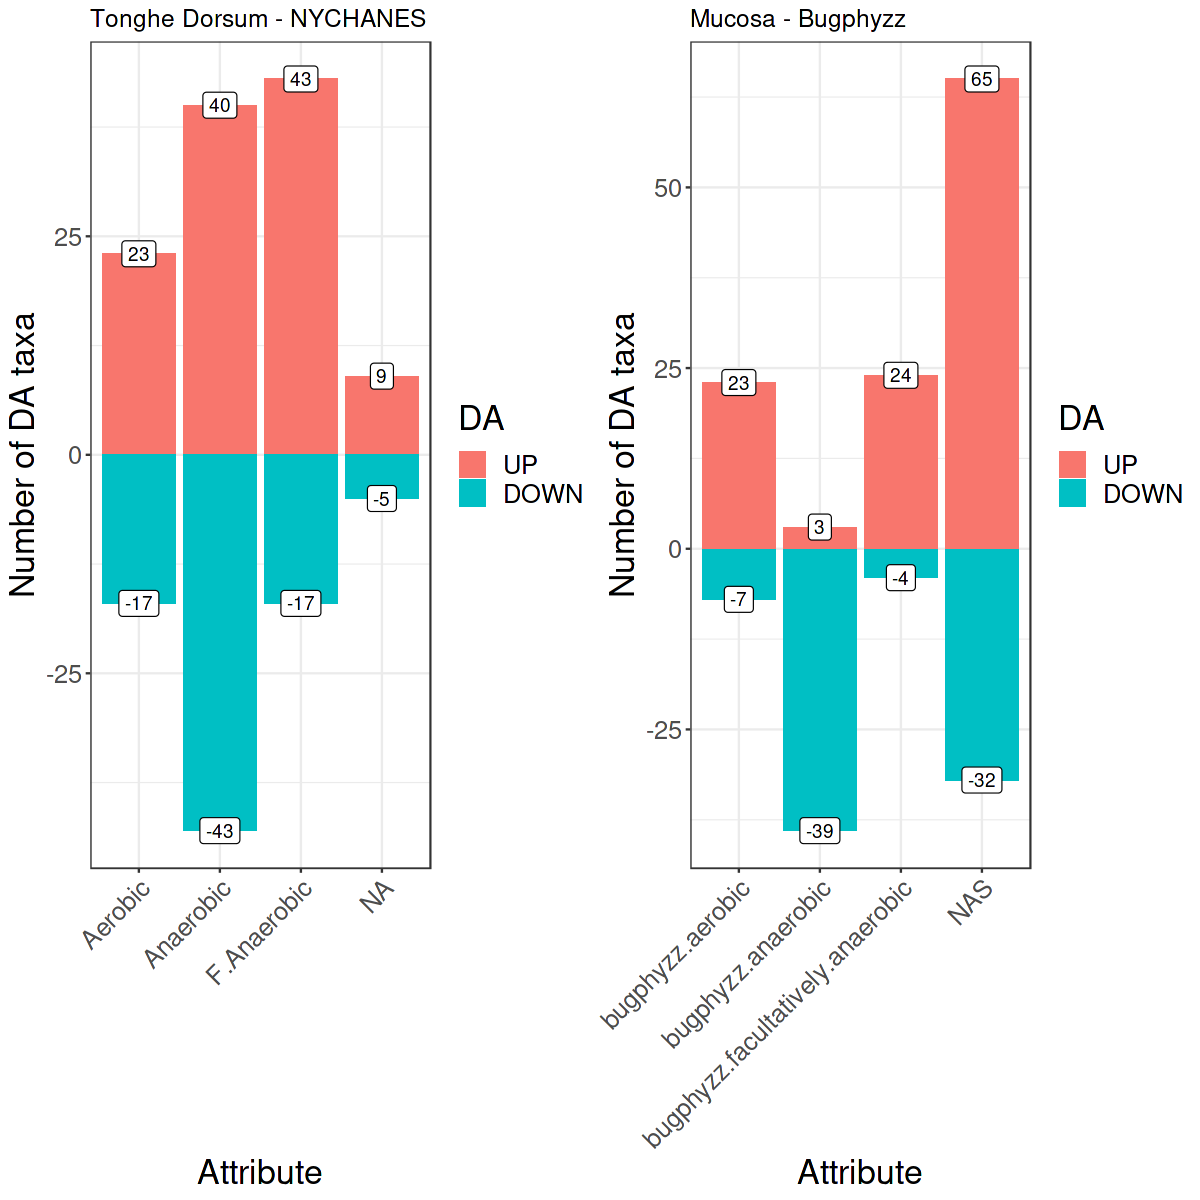

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggpubr::ggarrange(p1, p2, align = "h")

## Enrichment Fisher

In [24]:
# Convert from deseq object to SummarizedExperiment
seDESEQ <- SummarizedExperiment::SummarizedExperiment(
    assays = S4Vectors::SimpleList(counts = counts(dds)),
    rowData = rowData(dds),
    colData = colData(dds)
)

In [25]:
seDESEQ

class: SummarizedExperiment 
dim: 567 71 
metadata(0):
assays(1): counts
rownames(567): OTU_97.30326 OTU_97.31247 ... OTU_97.44523 OTU_97.45307
rowData names(47): SUPERKINGDOM PHYLUM ... DA.UP DA.DOWN
colnames(71): 700021685 700021817 ... 700114006 700114335
colData names(10): RSID VISITNO ... sizeFactor replaceable

### NYC HANES

In [26]:
nyc_hanes_attributes <- c("nychanes.Aerobic", "nychanes.Anaerobic", "nychanes.F.Anaerobic")
contingency_tbls_nychanes <- contingencyTable(seDESEQ, diffcols = c("DA.UP", "DA.DOWN"), sigcols = nyc_hanes_attributes)

In [27]:
lapply(contingency_tbls_nychanes, function(x) knitr::kable(x))

$DA.UP_nychanes.Aerobic


|        | nychanes.Aerobic| Notnychanes.Aerobic|
|:-------|----------------:|-------------------:|
|Diff    |               23|                  92|
|NotDiff |               49|                 403|

$DA.UP_nychanes.Anaerobic


|        | nychanes.Anaerobic| Notnychanes.Anaerobic|
|:-------|------------------:|---------------------:|
|Diff    |                 40|                    75|
|NotDiff |                132|                   320|

$DA.UP_nychanes.F.Anaerobic


|        | nychanes.F.Anaerobic| Notnychanes.F.Anaerobic|
|:-------|--------------------:|-----------------------:|
|Diff    |                   43|                      72|
|NotDiff |                  242|                     210|

$DA.DOWN_nychanes.Aerobic


|        | nychanes.Aerobic| Notnychanes.Aerobic|
|:-------|----------------:|-------------------:|
|Diff    |               17|                  65|
|NotDiff |               55|                 430|

$DA.DOWN_nychanes.Anaerobic


|     

In [28]:
fisher_nychanes <- enrichmentTest(contingency_tbls_nychanes) %>% 
    suppressWarnings() %>% 
    separate(col = con.table, into = c("Direction", "Attribute"), sep = "_") %>% 
    mutate(Direction = sub("^DA\\.", "", Direction), Attribute = sub("nychanes\\.", "", Attribute))

In [29]:
fisher_nychanes

Direction,Attribute,p.value,odds.ratio,ci.up,ci.lo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DOWN,Anaerobic,4.871090e-06,3.0316700,4.8648767,1.8892613
UP,Aerobic,8.544210e-03,2.0709255,3.5409194,1.2111917
DOWN,Aerobic,1.825674e-02,2.0724159,3.7419131,1.1477839
UP,Anaerobic,1.473776e-01,1.2975384,1.9951069,0.8438675
UP,F.Anaerobic,9.993362e-01,0.5208247,0.7903580,0.3432095
DOWN,F.Anaerobic,1.000000e+00,0.2164271,0.3754746,0.1247507


#### Plot of Odds Ratio

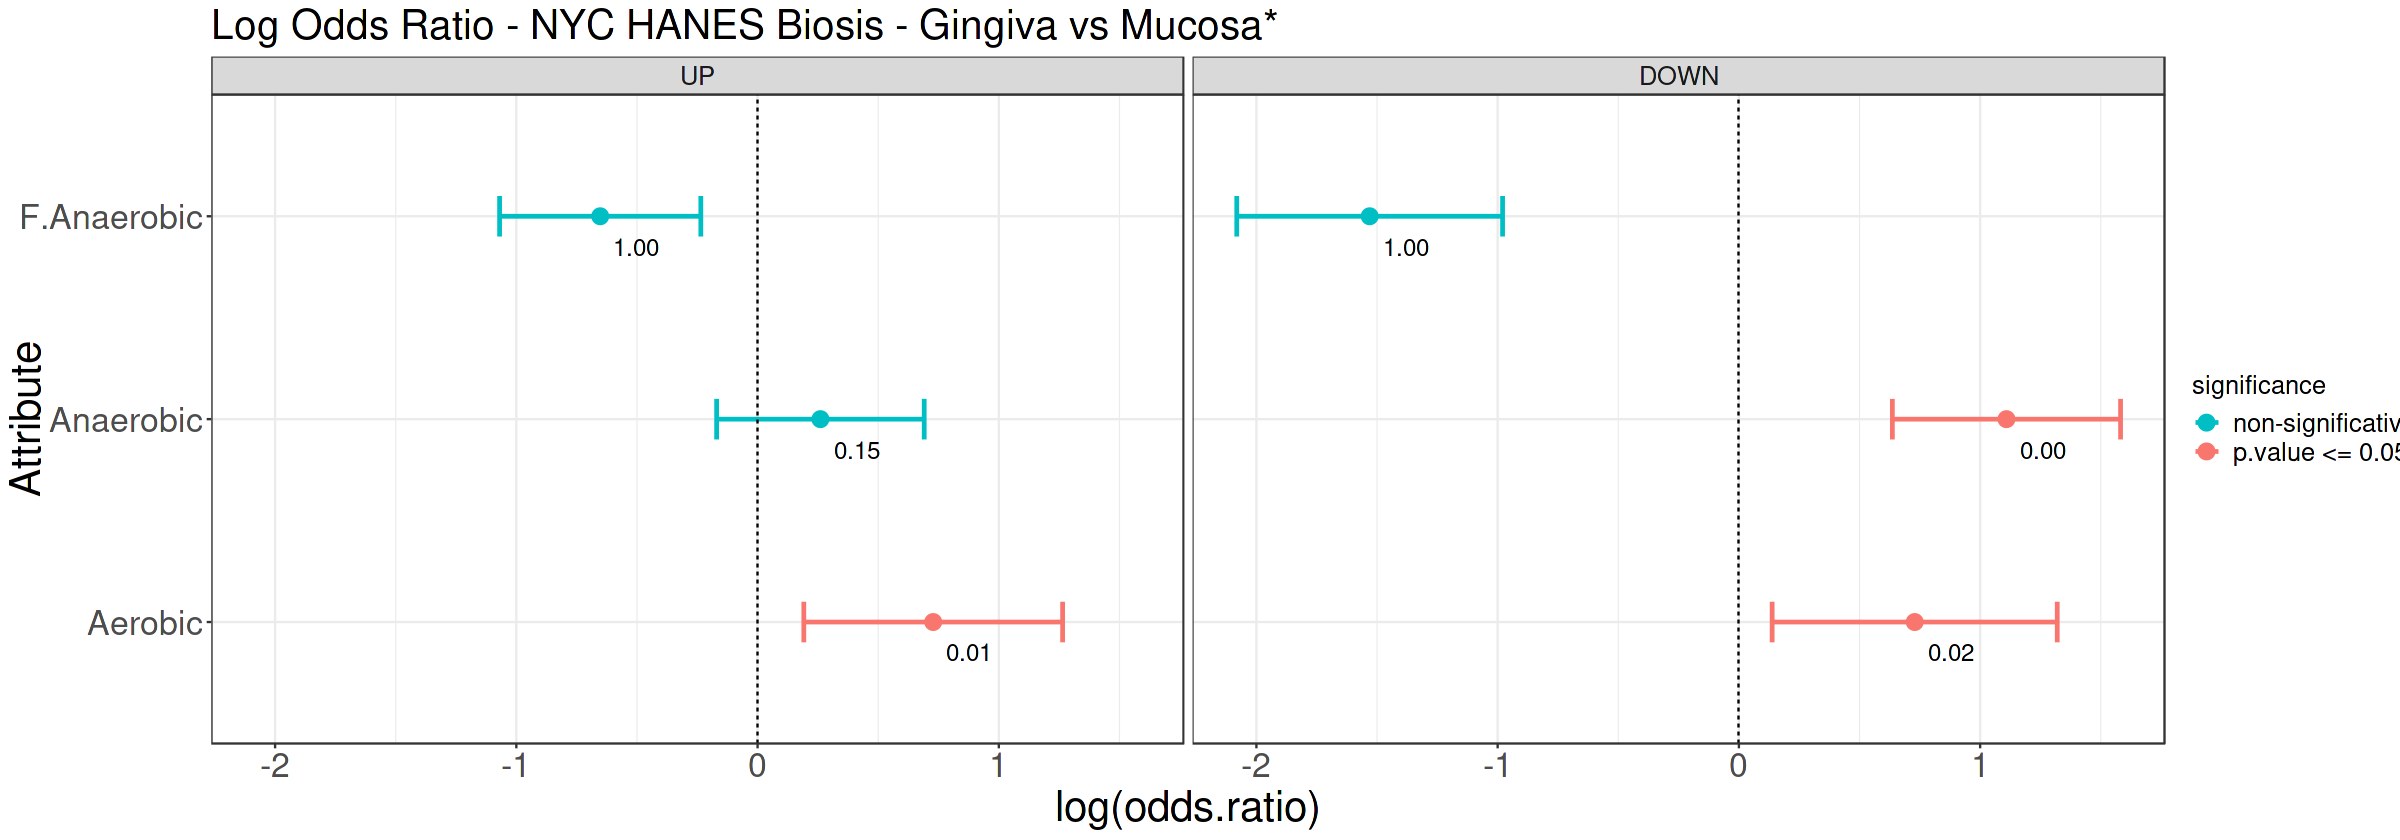

In [30]:
options(repr.plot.width = 20, repr.plot.height = 7)
(
p3 <- fisher_nychanes %>% 
    mutate(Direction = factor(Direction, levels = c("UP", "DOWN")),
          significance = ifelse(p.value <= 0.05, "p.value <= 0.05", "non-significative")) %>% 
    ggplot(aes(Attribute, log(odds.ratio))) +
    geom_point(aes(color = significance), size = 4) +
    geom_text(aes(label = sprintf("%0.2f", round(p.value, digits = 2))), nudge_y = 0.15, nudge_x = -0.15, size = 5) +
    geom_errorbar(aes(ymin = log(ci.lo), ymax = log(ci.up), color = significance), width = 0.2, size = 1) +
    geom_hline(yintercept = log(1), linetype = 2) +
    facet_wrap(~Direction) +
    scale_color_discrete(direction = -1) +
    labs(title = "Log Odds Ratio - NYC HANES Biosis - Gingiva vs Mucosa*") +   
    theme_bw() +
    theme(title = element_text(size = 20),
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 25),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        strip.text = element_text(size = 15)
    ) +
    coord_flip()
)

In [31]:
bugphyzz_attributes <- c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic")
contingency_tbls_bugphyzz <- contingencyTable(seDESEQ, diffcols = c("DA.UP", "DA.DOWN"), sigcols = bugphyzz_attributes)

In [32]:
lapply(contingency_tbls_bugphyzz, function(x) knitr::kable(x))

$DA.UP_bugphyzz.aerobic


|        | bugphyzz.aerobic| Notbugphyzz.aerobic|
|:-------|----------------:|-------------------:|
|Diff    |               23|                  92|
|NotDiff |               21|                 431|

$DA.UP_bugphyzz.anaerobic


|        | bugphyzz.anaerobic| Notbugphyzz.anaerobic|
|:-------|------------------:|---------------------:|
|Diff    |                  3|                   112|
|NotDiff |                 68|                   384|

$DA.UP_bugphyzz.facultatively.anaerobic


|        | bugphyzz.facultatively.anaerobic| Notbugphyzz.facultatively.anaerobic|
|:-------|--------------------------------:|-----------------------------------:|
|Diff    |                               24|                                  91|
|NotDiff |                              128|                                 324|

$DA.DOWN_bugphyzz.aerobic


|        | bugphyzz.aerobic| Notbugphyzz.aerobic|
|:-------|----------------:|-------------------:|
|Diff    |                7| 

In [33]:
fisher_bugphyzz <- enrichmentTest(contingency_tbls_bugphyzz) %>% 
    suppressWarnings() %>% 
    separate(col = con.table, into = c("Direction", "Attribute"), sep = "_") %>% 
    mutate(Direction = sub("^DA\\.", "", Direction), Attribute = sub("bugphyzz\\.", "", Attribute))

In [34]:
fisher_bugphyzz

Direction,Attribute,p.value,odds.ratio,ci.up,ci.lo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DOWN,anaerobic,1.266530e-18,12.6707339,22.0756052,7.27262040
UP,aerobic,7.977013e-07,5.0988058,9.4820196,2.74180201
DOWN,aerobic,4.577160e-01,1.1880795,2.6447772,0.53370576
UP,facultatively.anaerobic,9.602386e-01,0.6761710,1.1002511,0.41554810
UP,anaerobic,9.999927e-01,0.1746310,0.4889510,0.06237021
DOWN,facultatively.anaerobic,1.000000e+00,0.1302837,0.3282869,0.05170432


#### Plot of odds ratio

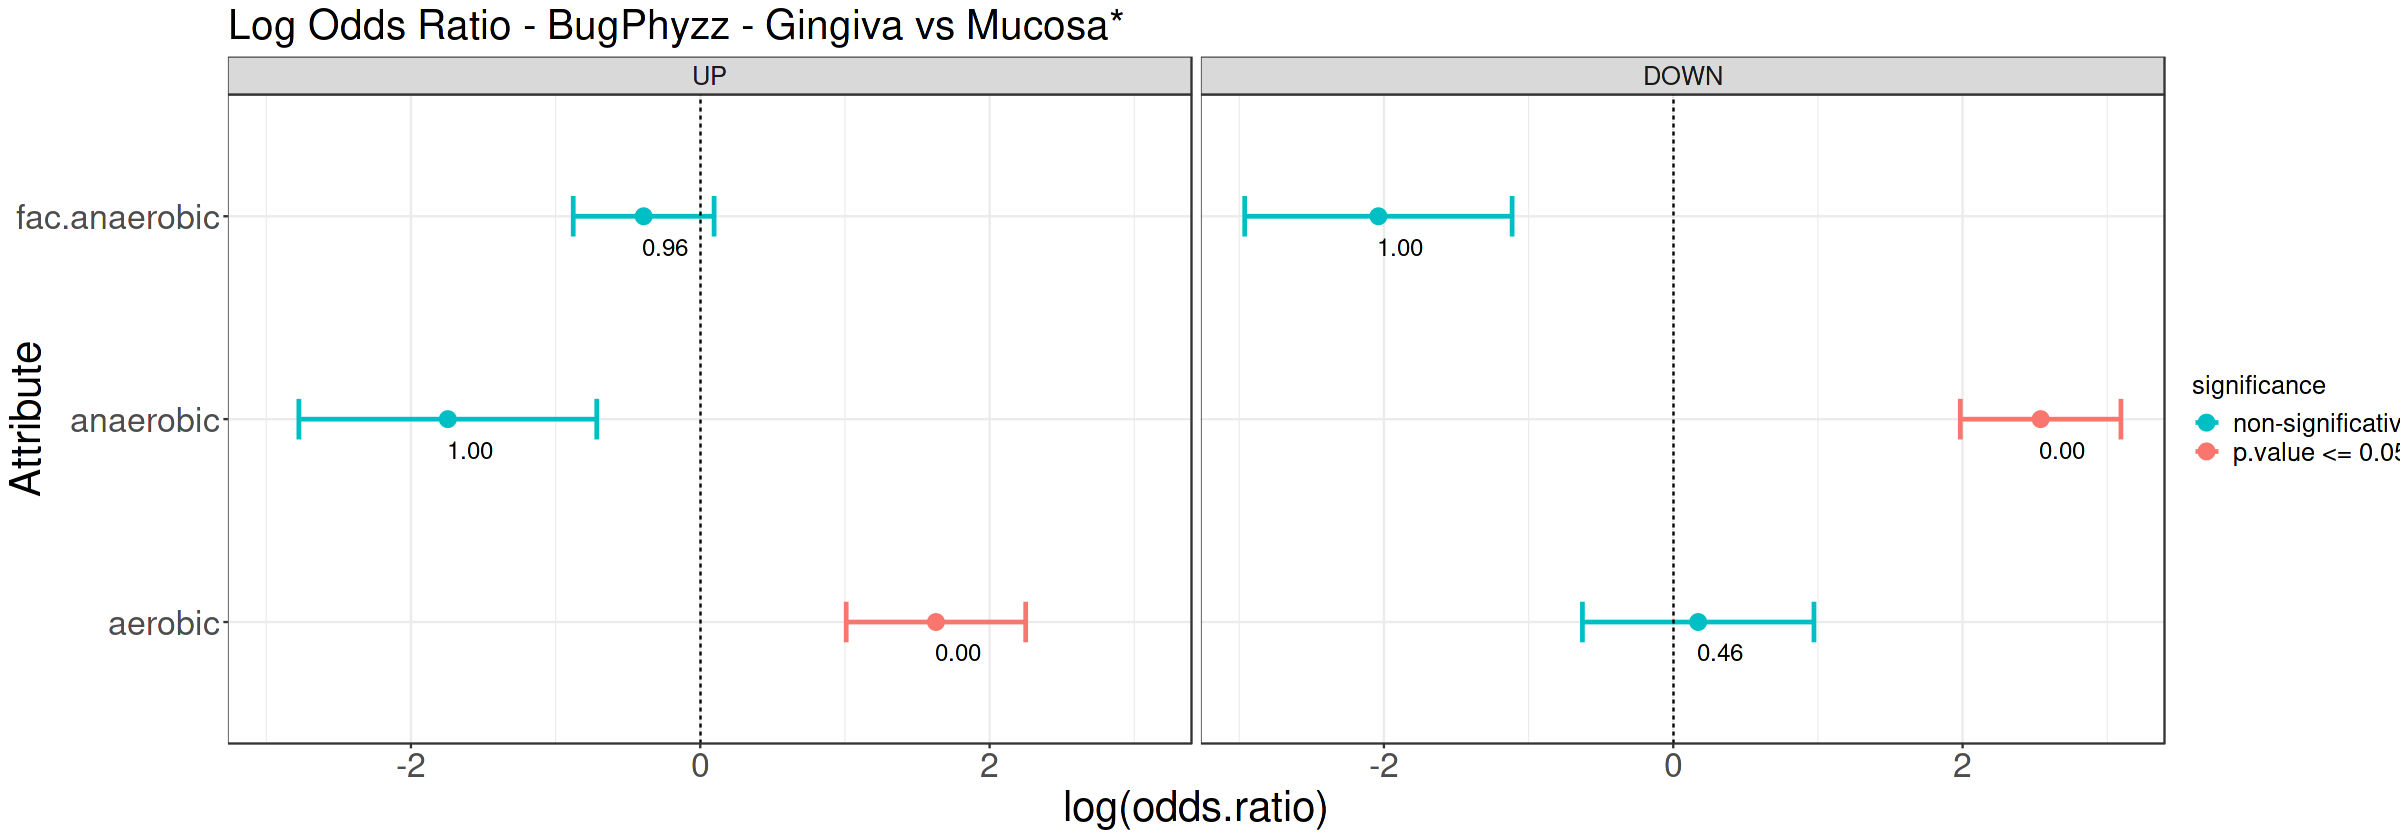

In [35]:
options(repr.plot.width = 20, repr.plot.height = 7)
(
p4 <- fisher_bugphyzz %>% 
    mutate(Direction = factor(Direction, levels = c("UP", "DOWN")),
          significance = ifelse(p.value <= 0.05, "p.value <= 0.05", "non-significative"))  %>% 
    ggplot(aes(Attribute, log(odds.ratio))) +
    geom_text(aes(label = sprintf("%0.2f", round(p.value, digits = 2))), nudge_y = 0.15, nudge_x = -0.15, size = 5) +
    geom_point(aes(color = significance), size = 4) +
    geom_errorbar(aes(ymin = log(ci.lo), ymax = log(ci.up), color = significance), width = 0.2, size = 1) +
    geom_hline(yintercept = log(1), linetype = 2) +
    facet_wrap(~Direction) +
    scale_color_discrete(direction = -1) +
    scale_x_discrete(labels = c("aerobic", "anaerobic", "fac.anaerobic")) +
    labs(title = "Log Odds Ratio - BugPhyzz - Gingiva vs Mucosa*") +
    theme_bw() +
    theme(title = element_text(size = 20),
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 25),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        strip.text = element_text(size = 15)
    ) +
    coord_flip()
)

### Enrichment Browser

In [36]:
nychanes_sets = microbeScores::makeMicrobeSets(x = seDESEQ, cols = c("nychanes.Aerobic", "nychanes.Anaerobic", "nychanes.F.Anaerobic"))

In [37]:
seDESEQ_ora_nychanes_default <- EnrichmentBrowser::sbea(method = "ora", se = seDESEQ,  gs = nychanes_sets, alpha = 0.1, perm=0)

In [38]:
EnrichmentBrowser::gsRanking(seDESEQ_ora_nychanes_default, signif.only = TRUE)

DataFrame with 2 rows and 4 columns
            GENE.SET  NR.GENES NR.SIG.GENES      PVAL
         <character> <numeric>    <numeric> <numeric>
1 nychanes.Anaerobic       165           83  0.000001
2   nychanes.Aerobic        72           40  0.000119

In [39]:
bugphyzz_sets <- microbeScores::makeMicrobeSets(x = seDESEQ, cols = c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic"))

In [40]:
EnrichmentBrowser::sbea(method = "ora", se = seDESEQ, gs = bugphyzz_sets, alpha = 0.1, perm = 0) %>% 
    EnrichmentBrowser::gsRanking(signif.only = TRUE) # None was found significative

DataFrame with 2 rows and 4 columns
            GENE.SET  NR.GENES NR.SIG.GENES      PVAL
         <character> <numeric>    <numeric> <numeric>
1   bugphyzz.aerobic        44           30  6.12e-06
2 bugphyzz.anaerobic        71           42  1.21e-05